## Generating Intermediary Data for Non-Overlapping Evolutionary Models

Oh no! Unfortunately our new evolutionary models for brown dwarf masses do not align with those previously implemented, leaving a mass gap. To address this, we have decided to use Gaussian processes to fit the two data regimes (Phillips and Pisa) and generate the associated data in this range. The parameters in question are mass, luminosity, effective temperature, and log gravity. This notebook shows an example case for solar metallicity and a log age of ~7.13.

In [1]:
# importing necessary packages
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
# importing compatible age fits files 
phillips = '/System/Volumes/Data/mnt/g/lu/models/evolution/Phillips2020/iso/z00/iso_7.128205127364955.fits'
pisa = '/System/Volumes/Data/mnt/g/lu/models/evolution/Pisa2011/iso/z015/iso_7.13.fits'

# loading tables and extracting data
phil_tbl = Table.read(phillips, format='fits')
pisa_tbl = Table.read(pisa, format='fits')

phil_mass = phil_tbl['Mass']
pisa_mass = pisa_tbl['col3']

phil_Teff = phil_tbl['Teff']
pisa_Teff = pisa_tbl['col2']

phil_L = phil_tbl['Luminosity']
pisa_L = pisa_tbl['col1']

phil_logg = phil_tbl['Gravity']
pisa_logg = pisa_tbl['col4']

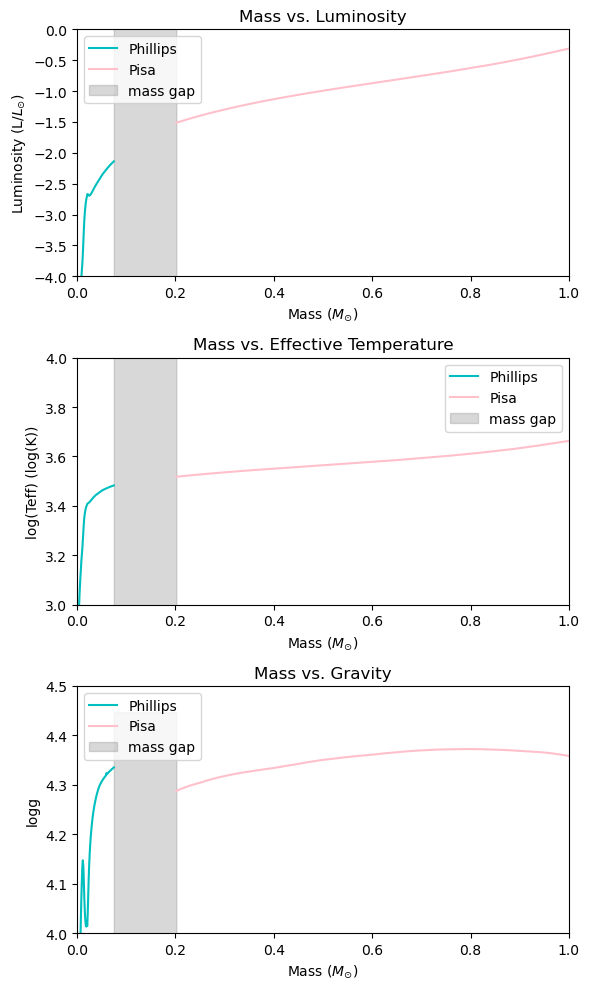

In [3]:
# creating graphs of mass vs. luminosity, Teff, and gravity
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

# create array for mass gap
mass_gap = np.linspace(np.max(phil_mass), np.min(pisa_mass), 1000)

# mass vs. luminosity
axs[0].plot(phil_mass, phil_L, color='c', label='Phillips')
axs[0].plot(pisa_mass, pisa_L, color='pink', label='Pisa')
axs[0].set_title('Mass vs. Luminosity') # for logAge=7.13')
y_min0 = axs[0].get_ylim()[0]
y_max0 = axs[0].get_ylim()[1]
axs[0].fill_between(mass_gap, y_min0, y_max0, color='gray', label='mass gap', alpha=0.3)
axs[0].set_xlabel('Mass ($M_{\odot}$)')
axs[0].set_ylabel('Luminosity (L/$L_{\odot}$)')
axs[0].set_xlim(0,1)
axs[0].set_ylim(-4,0)
axs[0].legend()

# mass vs. Teff
axs[1].plot(phil_mass, phil_Teff, color='c', label='Phillips')
axs[1].plot(pisa_mass, pisa_Teff, color='pink', label='Pisa')
y_min1 = axs[1].get_ylim()[0]
y_max1 = axs[1].get_ylim()[1]
axs[1].fill_between(mass_gap, y_min1, y_max1, color='gray', label='mass gap', alpha=0.3)
axs[1].set_title('Mass vs. Effective Temperature') # for logAge=7.13')
axs[1].set_xlabel('Mass ($M_{\odot}$)')
axs[1].set_ylabel('log(Teff) (log(K))')
axs[1].set_xlim(0,1)
axs[1].set_ylim(3,4)
axs[1].legend()

# mass vs. logg (problem child)
axs[2].plot(phil_mass, phil_logg, color='c', label='Phillips')
axs[2].plot(pisa_mass, pisa_logg, color='pink', label='Pisa')
y_min2 = axs[2].get_ylim()[0]
y_max2 = axs[2].get_ylim()[1]
axs[2].fill_between(mass_gap, y_min2, y_max2, color='gray', label='mass gap', alpha=0.3)
axs[2].set_title('Mass vs. Gravity') # for logAge=7.13'
axs[2].set_xlabel('Mass ($M_{\odot}$)')
axs[2].set_ylabel('logg')
axs[2].set_xlim(0,1)
axs[2].set_ylim(4,4.5)
axs[2].legend()

fig.tight_layout()
plt.legend()
plt.show()

From these zoomed in graphs it becomes clear that though a mass gap is present, luminosty and effective temperature still seem to line up if a model connects them. In contrast, the graph for log gravity is very clearly disconnected, which is worth refining as new models continue to be generated. To best address this problem, we decided to use GaussianProcessRegressor with the Matern kernel, as through trial and error this appeared to be the best fit. We then decided to generate a chi-squared heat map for luminosity to find the ideal parameters for length_scale and nu. This was done with and without the use of the kFold class from sklearn, with a determination that using it produces a much better fit.

In [4]:
# creating arrays
## mass
phil_mass = phil_tbl['Mass']
pisa_mass = pisa_tbl['col3']
combined_masses = np.concatenate([phil_mass, pisa_mass])

## Teff
phil_Teff = phil_tbl['Teff']
pisa_Teff = pisa_tbl['col2']
combined_Teff = np.concatenate([phil_Teff, pisa_Teff])

## Luminosity
phil_L = phil_tbl['Luminosity']
pisa_L = pisa_tbl['col1']
combined_L = np.concatenate([phil_L, pisa_L])

## logg
phil_logg = phil_tbl['Gravity']
pisa_logg = pisa_tbl['col4']
combined_logg = np.concatenate([phil_logg, pisa_logg])
print(np.max(phil_mass), np.min(pisa_mass))

0.075 0.2019


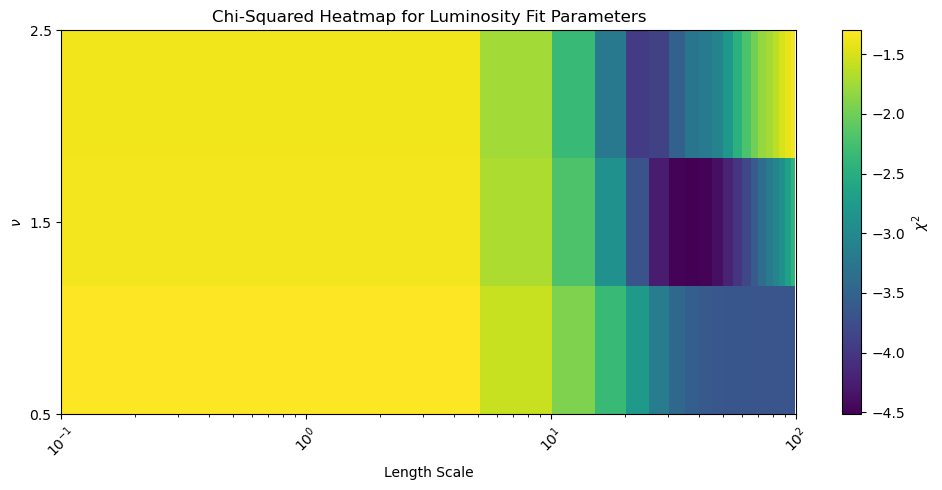

In [25]:
### USING SKLEARN

# creating input array (mass) and output array (luminosity)
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Define grid
length_scales = np.logspace(-1, 2, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map = np.zeros((len(nus), len(length_scales)))
N_data = len(y)
N_params = 2

kf = KFold(n_splits=5, shuffle=True, random_state=42)
chi2_map = np.zeros((len(nus), len(length_scales)))

for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)

        residuals = []
        try:
            for train_idx, test_idx in kf.split(X):
                gp.fit(X[train_idx], y[train_idx])
                y_pred = gp.predict(X[test_idx])
                residuals.append((y[test_idx] - y_pred)**2)

            residuals = np.concatenate(residuals)
            chi2 = np.sum(residuals)  # Assume unity residuals
            chi2_red = chi2 / (len(y) - N_params)  # Reduced chi^2
            chi2_map[i, j] = np.log10(chi2_red)
        except Exception as e:
            chi2_map[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map, aspect='auto', origin='lower',
                extent=[length_scales[0], length_scales[-1], 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(length_scales, labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.xscale('log')
plt.title('Chi-Squared Heatmap for Luminosity Fit Parameters')
plt.tight_layout()
plt.show()

In [26]:
i_best, j_best = np.unravel_index(np.nanargmin(chi2_map), chi2_map.shape)
best_nu = nus[i_best]
best_length_scale = length_scales[j_best]
print(best_nu, best_length_scale)

1.5 1.2742749857031335


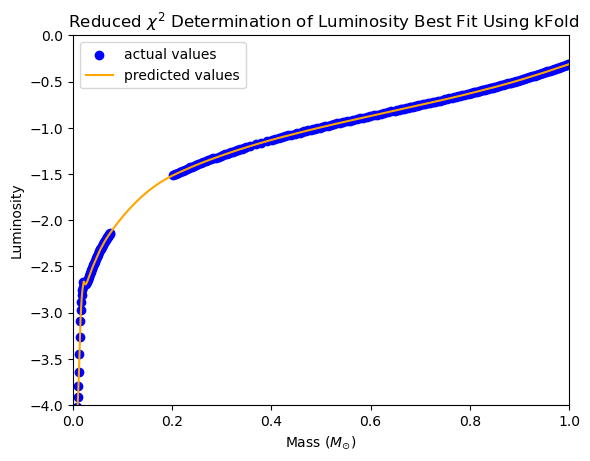

In [7]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (luminosity)
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale, nu=best_nu)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y)
y_pred_1, sigma_1 = gp.predict(x, return_std=True)
#chi2 = np.sum((y - y_pred_1)**2) #unit test for 2d function
#print(chi2)

plt.figure()
plt.scatter(X, combined_L, color='blue', label='actual values')
plt.plot(x, y_pred_1, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Luminosity')
plt.title(' Reduced $\chi^2$ Determination of Luminosity Best Fit Using kFold')
plt.xlim(0, 1)
plt.ylim(-4,0)
plt.legend()
plt.show()

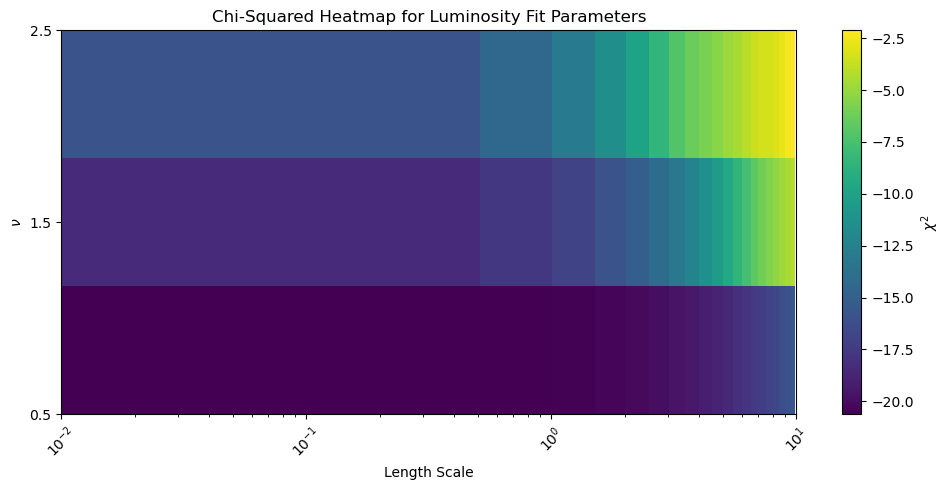

In [8]:
### WITHOUT KFOLD
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Define grid
length_scales = np.logspace(-2, 1, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map = np.zeros((len(nus), len(length_scales)))
N_data = len(y)
N_params = 2

chi2_map = np.zeros((len(nus), len(length_scales)))

for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)

        try:
            gp.fit(X, y)
            y_pred = gp.predict(X)
            residuals = (y - y_pred)**2

            chi2 = np.sum(residuals)  # assume unity residuals
            chi2_red = chi2 / (N_data - N_params)  # reduced chi^2
            chi2_map[i, j] = np.log10(chi2_red)

        except Exception as e:
            print(f"Error at nu={nu}, length_scale={ls}: {e}")
            chi2_map[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map, aspect='auto', origin='lower',
                extent=[length_scales[0], length_scales[-1], 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(length_scales, labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.xscale('log')
plt.title('Chi-Squared Heatmap for Luminosity Fit Parameters')
plt.tight_layout()
plt.show()


In [9]:
i_best, j_best = np.unravel_index(np.nanargmin(chi2_map), chi2_map.shape)
best_nu = nus[i_best]
best_length_scale = length_scales[j_best]
print(best_nu, best_length_scale)

0.5 0.01


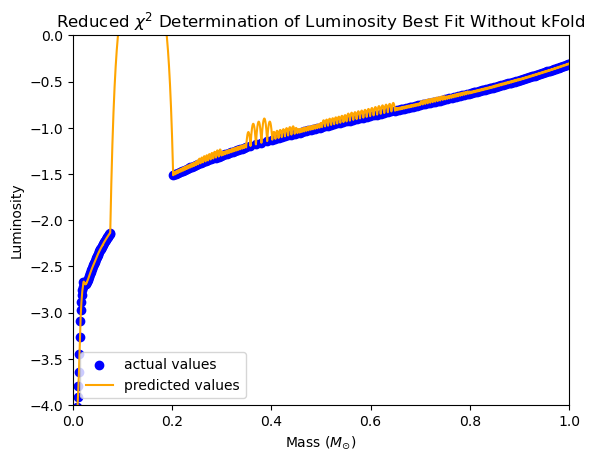

In [10]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y = combined_L   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale, nu=best_nu)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y)
y_pred_1, sigma_1 = gp.predict(x, return_std=True)
#chi2 = np.sum((y - y_pred_1)**2) #unit test for 2d function
#print(chi2)

plt.figure()
plt.scatter(X, combined_L, color='blue', label='actual values')
plt.plot(x, y_pred_1, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Luminosity')
plt.title('Reduced $\chi^2$ Determination of Luminosity Best Fit Without kFold')
plt.xlim(0, 1)
plt.ylim(-4,0)
plt.legend()
plt.show()

Through the use of kFold we produced a pretty good fit! We can then repeat the process to find the best parameters for effective temperature and log gravity.

In [11]:
#assume unity uncertainties and focus on gap between model and data -- gives small value but scale by relative 
#number of data points -- should give value close to 1

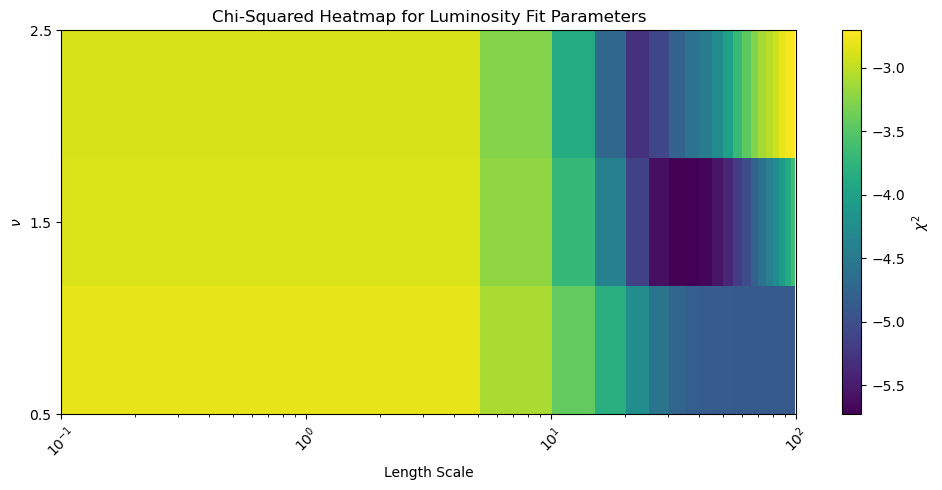

In [12]:
# creating input array (mass) and output array (teff)
X = combined_masses.reshape(-1, 1)
y_teff = combined_Teff   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Scale X and y
#X_scaler = StandardScaler()
#y_scaler = StandardScaler()

#X = X_scaler.fit_transform(combined_masses.reshape(-1, 1))
#y = y_scaler.fit_transform(combined_L.reshape(-1, 1)).ravel()

# Define grid
length_scales = np.logspace(-1, 2, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map_teff = np.zeros((len(nus), len(length_scales)))
N_data_teff = len(y_teff)
N_params = 2

kf = KFold(n_splits=5, shuffle=True, random_state=42)
chi2_map_teff = np.zeros((len(nus), len(length_scales)))

for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
        
        residuals_teff = []
        try:
            for train_idx, test_idx in kf.split(X):
                gp.fit(X[train_idx], y_teff[train_idx])
                y_pred_teff = gp.predict(X[test_idx])
                residuals_teff.append((y_teff[test_idx] - y_pred_teff)**2)

            residuals_teff = np.concatenate(residuals_teff) 
            chi2_teff = np.sum(residuals_teff)
            chi2_red_teff = chi2_teff / (N_data_teff - N_params)
            chi2_map_teff[i, j] = np.log10(chi2_red_teff)
        except Exception as e:
            chi2_map_teff[i, j] = np.nan
# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map_teff, aspect='auto', origin='lower',
                extent=[length_scales[0], length_scales[-1], 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(length_scales, labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.xscale('log')
plt.title('Chi-Squared Heatmap for Luminosity Fit Parameters')
plt.tight_layout()
plt.show()


In [13]:
i_best_Teff, j_best_Teff = np.unravel_index(np.nanargmin(chi2_map_teff), chi2_map_teff.shape)
best_nu_Teff = nus[i_best_Teff]
best_length_scale_Teff = length_scales[j_best_Teff]
print(best_nu_Teff, best_length_scale_Teff)

1.5 1.2742749857031335


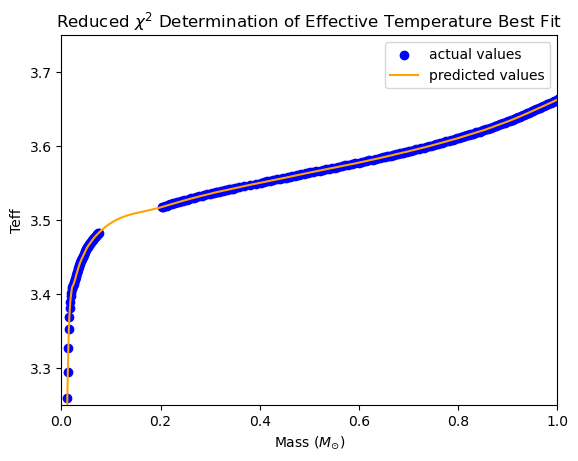

In [14]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y_teff = combined_Teff   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale_Teff, nu=best_nu_Teff)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y_teff)
y_pred_teff, sigma_teff = gp.predict(x, return_std=True)

plt.figure()
plt.scatter(X, combined_Teff, color='blue', label='actual values')
plt.plot(x, y_pred_teff, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Teff')
plt.title('Reduced $\chi^2$ Determination of Effective Temperature Best Fit')
plt.xlim(0, 1)
plt.ylim(3.25,3.75)
plt.legend()
plt.show()

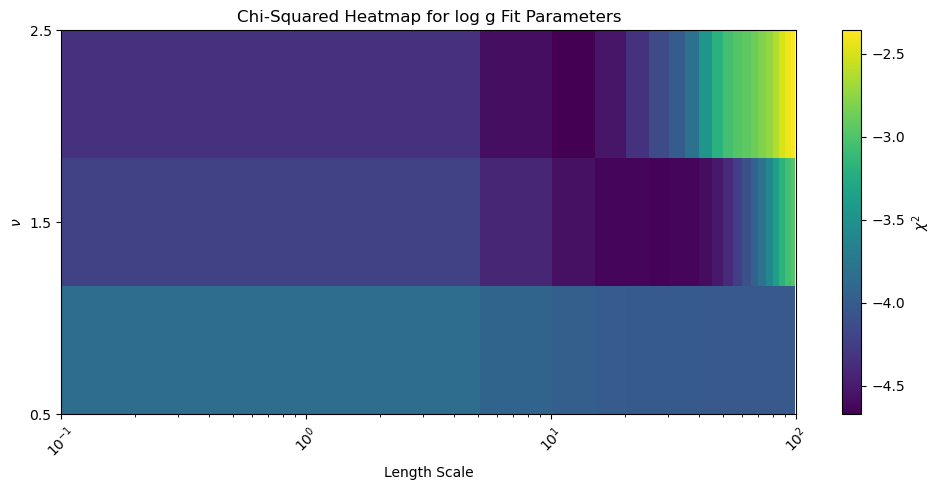

In [15]:
# creating input array (mass) and output array (luminosity)
X = combined_masses.reshape(-1, 1)
y_logg = combined_logg   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# Define grid
length_scales = np.logspace(-1, 2, 20)
nus = [0.5, 1.5, 2.5]  # available Matern values

chi2_map_logg = np.zeros((len(nus), len(length_scales)))
N_data_logg = len(y_logg)
N_params = 2

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, nu in enumerate(nus):
    for j, ls in enumerate(length_scales):
        kernel = Matern(length_scale=ls, nu=nu)
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
        
        residuals_logg = []
        try:
            for train_idx, test_idx in kf.split(X):
                gp.fit(X[train_idx], y_logg[train_idx])
                y_pred_logg = gp.predict(X[test_idx])
                residuals_logg.append((y_logg[test_idx] - y_pred_logg)**2)

            residuals_logg = np.concatenate(residuals_logg) 
            chi2_logg = np.sum(residuals_logg)
            chi2_red_logg = chi2_logg / (N_data_logg - N_params)
            chi2_map_logg[i, j] = np.log10(chi2_red_logg)
        except Exception as e:
            chi2_map_logg[i, j] = np.nan

# Plotting
plt.figure(figsize=(10, 5))
im = plt.imshow(chi2_map_logg, aspect='auto', origin='lower',
                extent=[length_scales[0], length_scales[-1], 0, len(nus)-1],
                cmap='viridis')
plt.colorbar(im, label=r'$\chi^2$')
plt.xticks(length_scales, labels=[f'{s:.3f}' for s in length_scales], rotation=45)
plt.yticks(range(len(nus)), labels=[str(n) for n in nus])
plt.xlabel('Length Scale')
plt.ylabel(r'$\nu$')
plt.xscale('log')
plt.title('Chi-Squared Heatmap for log g Fit Parameters')
plt.tight_layout()
plt.show()


In [16]:
i_best_logg, j_best_logg = np.unravel_index(np.nanargmin(chi2_map_logg), chi2_map_logg.shape)
best_nu_logg = nus[i_best_logg]
best_length_scale_logg = length_scales[j_best_logg]
print(best_nu_logg, best_length_scale_logg)

2.5 0.20691380811147897


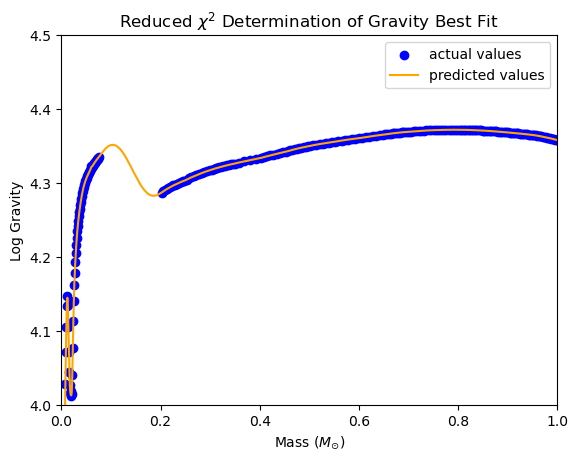

In [17]:
# Looking at physical interpretation of heatmap parameters

# creating input array (mass) and output array (everything else)
X = combined_masses.reshape(-1, 1)
y = combined_logg   #np.array([combined_Teff, combined_L, combined_logg])
x = np.linspace(np.min(phil_mass), np.max(pisa_mass), int(1e6)).reshape(-1, 1)

# trying different kernel types
kernel = Matern(length_scale=best_length_scale_logg, nu=best_nu_logg)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, normalize_y=True)
gp.fit(X, y_logg)
y_pred_logg, sigma_logg = gp.predict(x, return_std=True)

plt.figure()
plt.scatter(X, combined_logg, color='blue', label='actual values')
plt.plot(x, y_pred_logg, color='orange', label='predicted values')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Log Gravity')
plt.title('Reduced $\chi^2$ Determination of Gravity Best Fit')
plt.xlim(0, 1)
plt.ylim(4.0,4.5)
plt.legend()
plt.show()

### Generating Data in the Interpolated Region

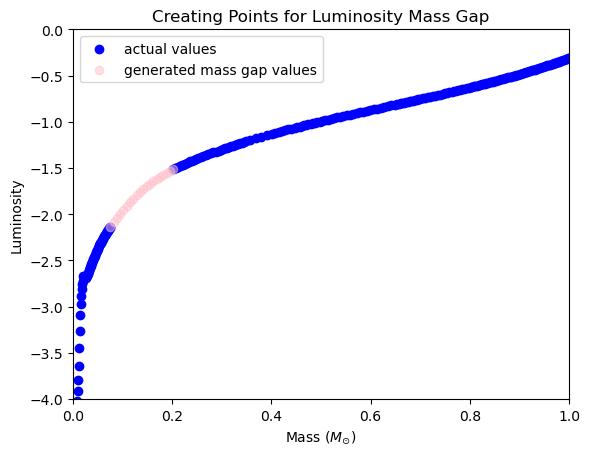

In [27]:
# starting with luminosity

best_kernel_L = Matern(length_scale=best_length_scale, nu=best_nu)
gp_best_L = GaussianProcessRegressor(kernel=best_kernel_L, optimizer=None, normalize_y=True)
gp_best_L.fit(X, y)

mass_vals = np.linspace(np.max(phil_mass), np.min(pisa_mass), 20).reshape(-1, 1)
L_pred = gp_best_L.predict(mass_vals)

plt.figure()
plt.scatter(X, combined_L, color='blue', label='actual values')
plt.scatter(mass_vals, L_pred, color='pink', alpha=0.5, label='generated mass gap values')
plt.title('Creating Points for Luminosity Mass Gap')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Luminosity')
plt.xlim(0, 1)
plt.ylim(-4,0)
plt.legend()
plt.show()

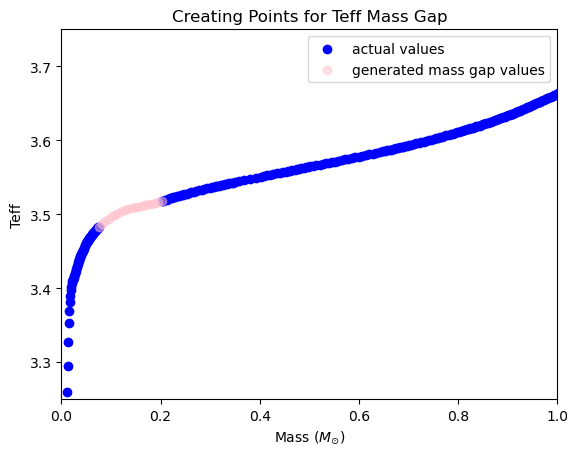

In [20]:
# moving to effective temperature

best_kernel_teff = Matern(length_scale=best_length_scale_Teff, nu=best_nu_Teff)
gp_best_teff = GaussianProcessRegressor(kernel=best_kernel_teff, optimizer=None, normalize_y=True)
gp_best_teff.fit(X, y_teff)

mass_vals = np.linspace(np.max(phil_mass), np.min(pisa_mass), 20).reshape(-1, 1)
teff_pred = gp_best_teff.predict(mass_vals)

plt.figure()
plt.scatter(X, combined_Teff, color='blue', label='actual values')
plt.scatter(mass_vals, teff_pred, color='pink', alpha=0.5, label='generated mass gap values')
plt.title('Creating Points for Teff Mass Gap')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('Teff')
plt.xlim(0, 1)
plt.ylim(3.25,3.75)
plt.legend()
plt.show()

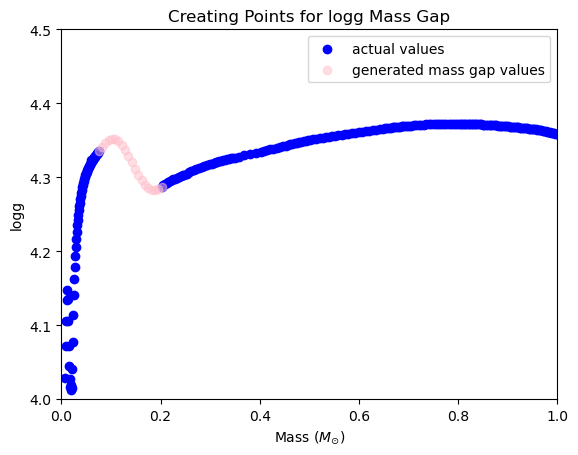

In [21]:
# moving to effective temperature

best_kernel_logg = Matern(length_scale=best_length_scale_logg, nu=best_nu_logg)
gp_best_logg = GaussianProcessRegressor(kernel=best_kernel_logg, optimizer=None, normalize_y=True)
gp_best_logg.fit(X, y_logg)

mass_vals = np.linspace(np.max(phil_mass), np.min(pisa_mass), 20).reshape(-1, 1)
logg_pred = gp_best_logg.predict(mass_vals)

plt.figure()
plt.scatter(X, combined_logg, color='blue', label='actual values')
plt.scatter(mass_vals, logg_pred, color='pink', alpha=0.5, label='generated mass gap values')
plt.title('Creating Points for logg Mass Gap')
plt.xlabel('Mass ($M_{\odot}$)')
plt.ylabel('logg')
plt.xlim(0, 1)
plt.ylim(4.0,4.5)
plt.legend()
plt.show()

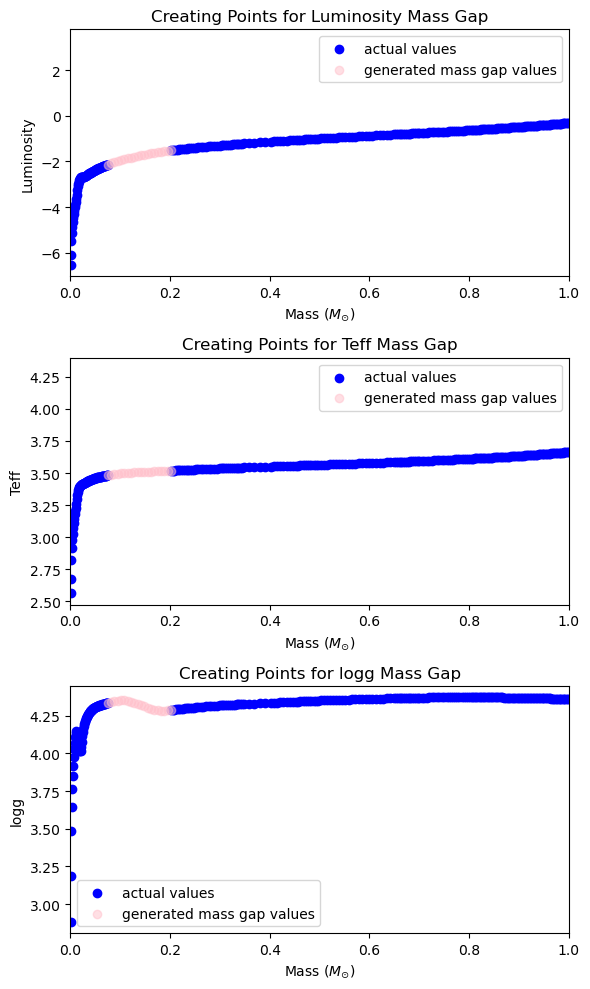

In [36]:
# creating graphs of mass vs. luminosity, Teff, and gravity
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

# plotting generated data for luminosity
axs[0].scatter(combined_masses, combined_L, color='blue', label='actual values')
axs[0].scatter(mass_vals, L_pred, color='pink', alpha=0.5, label='generated mass gap values')
axs[0].set_title('Creating Points for Luminosity Mass Gap')
axs[0].set_xlabel('Mass ($M_{\odot}$)')
axs[0].set_ylabel('Luminosity')
axs[0].set_xlim(0, 1)
#axs[0].set_ylim(-4,0)
axs[0].legend()

# mass vs. Teff
axs[1].scatter(combined_masses, combined_Teff, color='blue', label='actual values')
axs[1].scatter(mass_vals, teff_pred, color='pink', alpha=0.5, label='generated mass gap values')
axs[1].set_title('Creating Points for Teff Mass Gap')
axs[1].set_xlabel('Mass ($M_{\odot}$)')
axs[1].set_ylabel('Teff')
axs[1].set_xlim(0, 1)
#axs[1].set_ylim(3.25,3.75)
axs[1].legend()

# mass vs. logg (problem child)
axs[2].scatter(combined_masses, combined_logg, color='blue', label='actual values')
axs[2].scatter(mass_vals, logg_pred, color='pink', alpha=0.5, label='generated mass gap values')
axs[2].set_title('Creating Points for logg Mass Gap')
axs[2].set_xlabel('Mass ($M_{\odot}$)')
axs[2].set_ylabel('logg')
axs[2].set_xlim(0, 1)
#axs[2].set_ylim(4.0,4.5)
axs[2].legend()

fig.tight_layout()
plt.legend()
plt.show()

### Testing Fit Parameters for Another Cluster Age

In [23]:
# importing compatible age fits files 
phillips2 = '/System/Volumes/Data/mnt/g/lu/models/evolution/Phillips2020/iso/z00/iso_8.051282050278353.fits'
pisa2 = '/System/Volumes/Data/mnt/g/lu/models/evolution/Pisa2011/iso/z015/iso_8.00.fits'

# loading tables and extracting data
phil2_tbl = Table.read(phillips2, format='fits')
pisa2_tbl = Table.read(pisa2, format='fits')

phil2_mass = phil2_tbl['Mass']
pisa2_mass = pisa2_tbl['col3']
combined_masses2 = np.concatenate([phil2_mass, pisa2_mass])

phil2_teff = phil2_tbl['Teff']
pisa2_teff = pisa2_tbl['col2']
combined_teff2 = np.concatenate([phil2_teff, pisa2_teff])

phil2_L = phil2_tbl['Luminosity']
pisa2_L = pisa2_tbl['col1']
combined_L2 = np.concatenate([phil2_L, pisa2_L])

phil2_logg = phil2_tbl['Gravity']
pisa2_logg = pisa2_tbl['col4']
combined_logg2 = np.concatenate([phil2_logg, pisa2_logg])

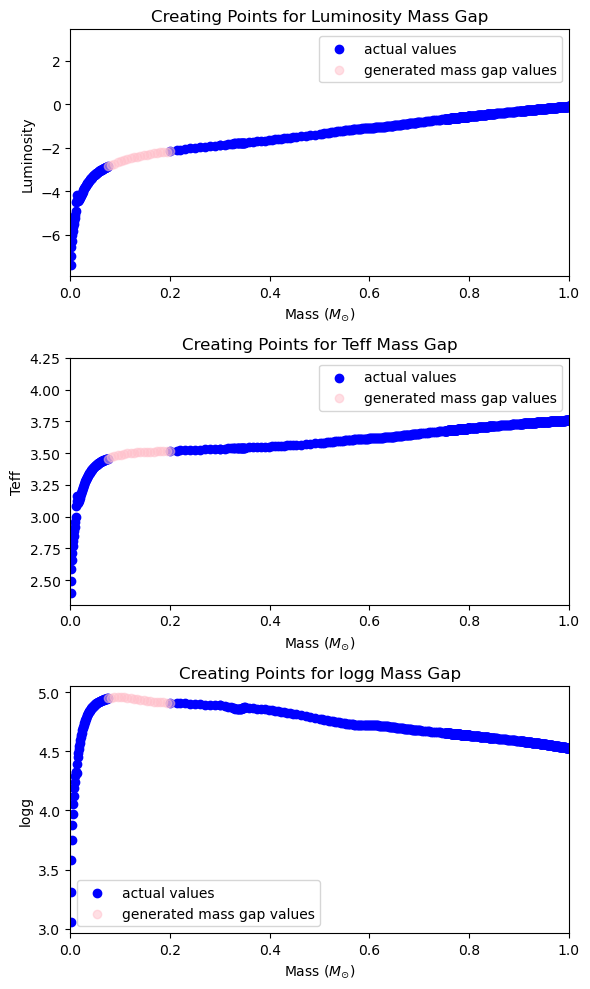

In [31]:
# creating graphs of mass vs. luminosity, Teff, and gravity
fig, axs = plt.subplots(3, 1, figsize=(6, 10))


# generated data for mass vs. luminosity
best_kernel_L2 = Matern(length_scale=best_length_scale, nu=best_nu)
gp_best_L2 = GaussianProcessRegressor(kernel=best_kernel_L2, optimizer=None, normalize_y=True)
gp_best_L2.fit(combined_masses2.reshape(-1, 1), combined_L2)

mass_vals2 = np.linspace(np.max(phil2_mass), np.min(pisa2_mass), 20).reshape(-1, 1)
L_pred2 = gp_best_L2.predict(mass_vals2)

# plotting generated data for luminosity
axs[0].scatter(combined_masses2, combined_L2, color='blue', label='actual values')
axs[0].scatter(mass_vals2, L_pred2, color='pink', alpha=0.5, label='generated mass gap values')
axs[0].set_title('Creating Points for Luminosity Mass Gap')
axs[0].set_xlabel('Mass ($M_{\odot}$)')
axs[0].set_ylabel('Luminosity')
axs[0].set_xlim(0, 1)
#axs[0].set_ylim(-4,0)
axs[0].legend()

# generated data for mass vs. teff
best_kernel_teff2 = Matern(length_scale=best_length_scale_Teff, nu=best_nu_Teff)
gp_best_teff2 = GaussianProcessRegressor(kernel=best_kernel_teff2, optimizer=None, normalize_y=True)
gp_best_teff2.fit(combined_masses2.reshape(-1, 1), combined_teff2)

teff_pred2 = gp_best_teff2.predict(mass_vals2)

# mass vs. Teff
axs[1].scatter(combined_masses2, combined_teff2, color='blue', label='actual values')
axs[1].scatter(mass_vals2, teff_pred2, color='pink', alpha=0.5, label='generated mass gap values')
axs[1].set_title('Creating Points for Teff Mass Gap')
axs[1].set_xlabel('Mass ($M_{\odot}$)')
axs[1].set_ylabel('Teff')
axs[1].set_xlim(0, 1)
#axs[1].set_ylim(3.25,3.75)
axs[1].legend()

# generated data for mass vs. logg
best_kernel_logg2 = Matern(length_scale=best_length_scale_logg, nu=best_nu_logg)
gp_best_logg2 = GaussianProcessRegressor(kernel=best_kernel_logg2, optimizer=None, normalize_y=True)
gp_best_logg2.fit(combined_masses2.reshape(-1, 1), combined_logg2)

logg_pred2 = gp_best_logg2.predict(mass_vals2)

# mass vs. logg (problem child)
axs[2].scatter(combined_masses2, combined_logg2, color='blue', label='actual values')
axs[2].scatter(mass_vals2, logg_pred2, color='pink', alpha=0.5, label='generated mass gap values')
axs[2].set_title('Creating Points for logg Mass Gap')
axs[2].set_xlabel('Mass ($M_{\odot}$)')
axs[2].set_ylabel('logg')
axs[2].set_xlim(0, 1)
#axs[2].set_ylim(4.0,4.5)
axs[2].legend()

fig.tight_layout()
plt.legend()
plt.show()

### Now for logAge = 6.00!

In [32]:
# importing compatible age fits files 
phillips3 = '/System/Volumes/Data/mnt/g/lu/models/evolution/Phillips2020/iso/z00/iso_6.0.fits'
pisa3 = '/System/Volumes/Data/mnt/g/lu/models/evolution/Pisa2011/iso/z015/iso_6.00.fits'

# loading tables and extracting data
phil3_tbl = Table.read(phillips3, format='fits')
pisa3_tbl = Table.read(pisa3, format='fits')

phil3_mass = phil3_tbl['Mass']
pisa3_mass = pisa3_tbl['col3']
combined_masses3 = np.concatenate([phil3_mass, pisa3_mass])

phil3_teff = phil3_tbl['Teff']
pisa3_teff = pisa3_tbl['col2']
combined_teff3 = np.concatenate([phil3_teff, pisa3_teff])

phil3_L = phil3_tbl['Luminosity']
pisa3_L = pisa3_tbl['col1']
combined_L3 = np.concatenate([phil3_L, pisa3_L])

phil3_logg = phil3_tbl['Gravity']
pisa3_logg = pisa3_tbl['col4']
combined_logg3 = np.concatenate([phil3_logg, pisa3_logg])

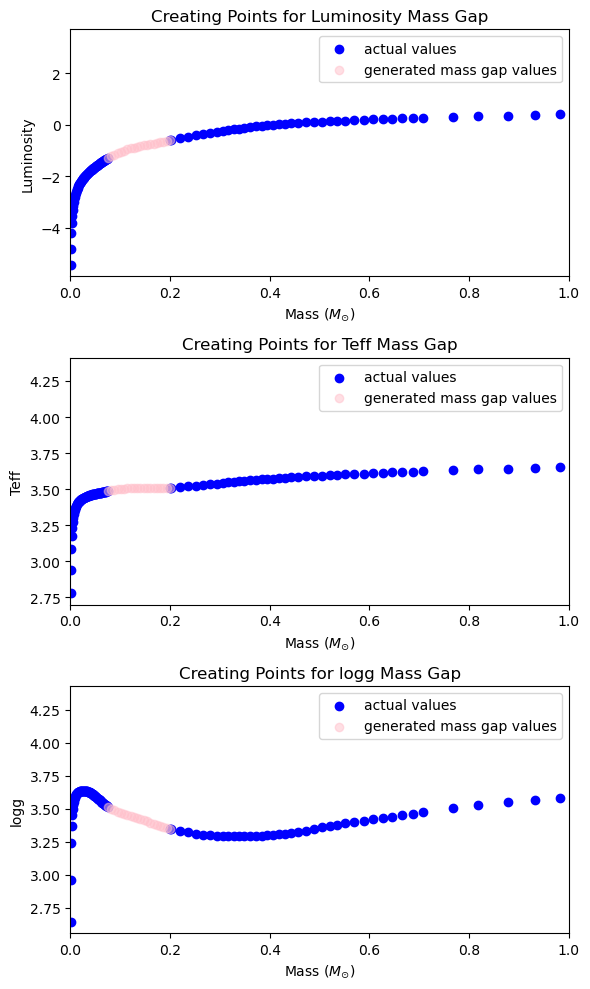

In [34]:
# creating graphs of mass vs. luminosity, Teff, and gravity
fig, axs = plt.subplots(3, 1, figsize=(6, 10))


# generated data for mass vs. luminosity
best_kernel_L3 = Matern(length_scale=best_length_scale, nu=best_nu)
gp_best_L3 = GaussianProcessRegressor(kernel=best_kernel_L3, optimizer=None, normalize_y=True)
gp_best_L3.fit(combined_masses3.reshape(-1, 1), combined_L3)

mass_vals3 = np.linspace(np.max(phil3_mass), np.min(pisa3_mass), 20).reshape(-1, 1)
L_pred3 = gp_best_L3.predict(mass_vals3)

# plotting generated data for luminosity
axs[0].scatter(combined_masses3, combined_L3, color='blue', label='actual values')
axs[0].scatter(mass_vals3, L_pred3, color='pink', alpha=0.5, label='generated mass gap values')
axs[0].set_title('Creating Points for Luminosity Mass Gap')
axs[0].set_xlabel('Mass ($M_{\odot}$)')
axs[0].set_ylabel('Luminosity')
axs[0].set_xlim(0, 1)
#axs[0].set_ylim(-4,0)
axs[0].legend()

# generated data for mass vs. teff
best_kernel_teff3 = Matern(length_scale=best_length_scale_Teff, nu=best_nu_Teff)
gp_best_teff3 = GaussianProcessRegressor(kernel=best_kernel_teff3, optimizer=None, normalize_y=True)
gp_best_teff3.fit(combined_masses3.reshape(-1, 1), combined_teff3)

teff_pred3 = gp_best_teff3.predict(mass_vals3)

# mass vs. Teff
axs[1].scatter(combined_masses3, combined_teff3, color='blue', label='actual values')
axs[1].scatter(mass_vals3, teff_pred3, color='pink', alpha=0.5, label='generated mass gap values')
axs[1].set_title('Creating Points for Teff Mass Gap')
axs[1].set_xlabel('Mass ($M_{\odot}$)')
axs[1].set_ylabel('Teff')
axs[1].set_xlim(0, 1)
#axs[1].set_ylim(3.25,3.75)
axs[1].legend()

# generated data for mass vs. logg
best_kernel_logg3 = Matern(length_scale=best_length_scale_logg, nu=best_nu_logg)
gp_best_logg3 = GaussianProcessRegressor(kernel=best_kernel_logg3, optimizer=None, normalize_y=True)
gp_best_logg3.fit(combined_masses3.reshape(-1, 1), combined_logg3)

logg_pred3 = gp_best_logg3.predict(mass_vals3)

# mass vs. logg (problem child)
axs[2].scatter(combined_masses3, combined_logg3, color='blue', label='actual values')
axs[2].scatter(mass_vals3, logg_pred3, color='pink', alpha=0.5, label='generated mass gap values')
axs[2].set_title('Creating Points for logg Mass Gap')
axs[2].set_xlabel('Mass ($M_{\odot}$)')
axs[2].set_ylabel('logg')
axs[2].set_xlim(0, 1)
#axs[2].set_ylim(4.0,4.5)
axs[2].legend()

fig.tight_layout()
plt.legend()
plt.show()

### Creating a Function to Apply Model to All Pisa/Phillips Files